# CIFAR10 Classification

### HW2 @ DL Course, Dr. Soleymani

*Full Name:* Ehsan Hassanbeygi

*SID:* 402211723

In this part of the assignment we want to do an image classification task using PyTorch on CIFAR10 dataset.

## Import Libraries

Import needed libraries

In [46]:
import torch
import torchvision
from torchvision import transforms
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score

## Device

Set device to work with (GPU or CPU)

In [47]:
def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)


torch.backends.cudnn.deterministic = True
set_seed(42)

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Transforms & Dataset & Dataloader

Here, you should download and load the dataset with the desire transforms. After that, you should split train dataset to train and validation sets. Finally, define the dataloaders for `train`, `validation` and `test`

In [48]:
classes = [
    "plane",
    "car",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
]

In [49]:
transform_train = transforms.Compose(
    [
        # transforms.Resize((224, 224)),
        transforms.RandomCrop(32, padding=4, padding_mode="reflect"),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.20, 0.20, 0.20), inplace=True),
    ]
)

transform_test = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.20, 0.20, 0.20)),
    ]
)

In [50]:
# inverse the normilize transform to restore the original data
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        tensor = tensor.clone()

        # Unnormalize the tensor for each channel
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)

        return tensor


norminv = UnNormalize(mean=(0.5, 0.5, 0.5), std=(0.20, 0.20, 0.20))

In [51]:
initial_trainset = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True, transform=transform_train
)

Files already downloaded and verified


In [53]:
val_size = int(0.1 * len(initial_trainset))
trainset, valset = torch.utils.data.random_split(
    initial_trainset, (len(initial_trainset) - val_size, val_size)
)

In [54]:
batch_size = 400
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False, num_workers=2)

In [55]:
testset = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True, transform=transform_test
)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

Files already downloaded and verified


## Visualization

Visualize 5 random images from each class in different columns

- **Hint**:  You can use `plt.subplots` for visualization

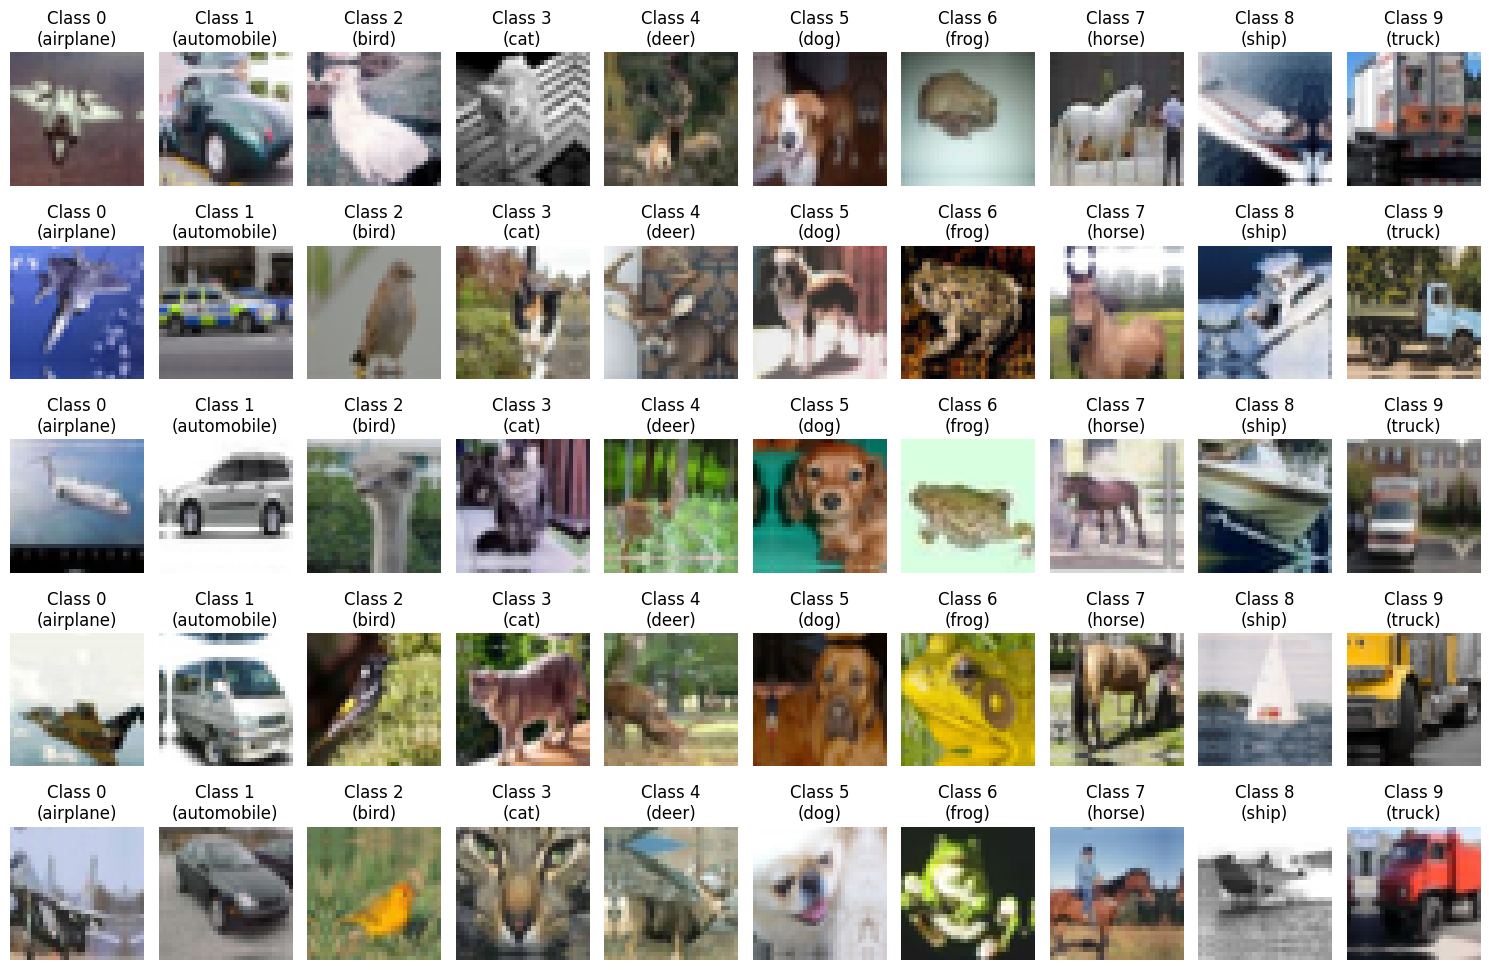

In [56]:
def get_random_indices(dataset, num_samples=5):
    random_indices = []
    for class_idx in range(len(dataset.classes)):
        class_indices = (
            (torch.tensor(dataset.targets) == class_idx).nonzero().squeeze(1)
        )
        random_indices.extend(
            class_indices[torch.randperm(len(class_indices))[:num_samples]].tolist()
        )
    return random_indices


fig, axs = plt.subplots(nrows=5, ncols=10, figsize=(15, 10))
for i, idx in enumerate(get_random_indices(initial_trainset)):
    img, class_idx = initial_trainset[idx]
    img = norminv(img)
    row_idx = i % 5
    col_idx = class_idx
    axs[row_idx, col_idx].imshow(
        img.permute(1, 2, 0)
    )  # Need to permute dimensions for matplotlib
    axs[row_idx, col_idx].set_title(
        f"Class {class_idx}\n({initial_trainset.classes[class_idx]})"
    )
    axs[row_idx, col_idx].axis("off")

plt.tight_layout()
plt.show()

## Model

Define your ResNet model here from scratch (You are not allowed to use the existing models in pytorch)

Our suggestion is to implement ResNet18

In [57]:
# class ResidualBlock(nn.Module):
#     def __init__(self, in_channels, out_channels, stride=1, downsample=None):
#         super(ResidualBlock, self).__init__()
#         self.conv1 = nn.Sequential(
#             nn.Conv2d(
#                 in_channels, out_channels, kernel_size=3, stride=stride, padding=1
#             ),
#             nn.BatchNorm2d(out_channels),
#             nn.ReLU(),
#         )
#         self.conv2 = nn.Sequential(
#             nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
#             nn.BatchNorm2d(out_channels),
#         )
#         self.downsample = downsample
#         self.relu = nn.ReLU()
#         self.out_channels = out_channels

#     def forward(self, x):
#         residual = x
#         out = self.conv1(x)
#         out = self.conv2(out)
#         if self.downsample:
#             residual = self.downsample(x)
#         out += residual
#         out = self.relu(out)
#         return out


class ResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResNetBlock, self).__init__()

        self.downsample = downsample
        self.conv1 = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size=3,
            stride=stride,
            padding=1,
            bias=False,
        )
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(
            out_channels,
            out_channels,
            kernel_size=3,
            padding=1,
            bias=False,
        )
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample is not None:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

In [58]:
class ResNet18(nn.Module):
    def __init__(self, img_channels, block, num_classes):
        super(ResNet18, self).__init__()
#         def init_weights(m):
#             if isinstance(m, nn.Linear):
#                 torch.nn.init.xavier_uniform_(m.weight)
#                 m.bias.data.fill_(0.01)

        layers = [2, 2, 2, 2]

        self.in_channels = 64
        # self.conv1 = nn.Conv2d(
        #     img_channels,
        #     self.in_channels,
        #     kernel_size=7,
        #     stride=2,
        #     padding=3,
        #     bias=False,
        # )
        # self.bn1 = nn.BatchNorm2d(self.in_channels)
        # self.relu = nn.ReLU(inplace=True)
        # self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        # self.layer1 = self._make_layer(block, 64, layers[0])
        # self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        # self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        # self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        # self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        # self.fc = nn.Linear(512, num_classes)
        self.model = nn.Sequential(
            nn.Conv2d(
                img_channels,
                self.in_channels,
                kernel_size=7,
                stride=2,
                padding=3,
                bias=False,
            ),
            nn.BatchNorm2d(self.in_channels),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            self._make_layer(block, 64, layers[0]),
            self._make_layer(block, 128, layers[1], stride=2),
            self._make_layer(block, 256, layers[2], stride=2),
            self._make_layer(block, 512, layers[3], stride=2),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(512, num_classes),
        )

        # use Xavier initialization for weights
#         self.model.apply(init_weights)

    def _make_layer(self, block, out_channels, block_count, stride=1):
        downsample = None
        if stride != 1:
            downsample = nn.Sequential(
                nn.Conv2d(
                    self.in_channels,
                    out_channels,
                    kernel_size=1,
                    stride=stride,
                    bias=False,
                ),
                nn.BatchNorm2d(out_channels),
            )
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))

        # Only the first block changes the number of channels
        self.in_channels = out_channels
        for _ in range(block_count - 1):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        # x = self.conv1(x)
        # x = self.bn1(x)
        # x = self.relu(x)
        # x = self.maxpool(x)
        # x = self.layer1(x)
        # x = self.layer2(x)
        # x = self.layer3(x)
        # x = self.layer4(x)
        # # print("Dimensions of the last convolutional feature map: ", x.shape)
        # x = self.avgpool(x)
        # x = torch.flatten(x, 1)
        # x = self.fc(x)
        
        return self.model(x)

In [59]:
# class ResNetBlock(torch.nn.Module):
#     def __init__(self, in_channels, out_channels, stride=1):
#         super(ResNetBlock, self).__init__()
#         pass

#     def forward(self, x):
#         pass


# class ResNet18(torch.nn.Module):
#     def __init__(self):
#         super(ResNet18, self).__init__()
#         pass

#     def forward(self, x):
#         pass

## Train

### Model instantiation

Create an instance of your model and move it to `device`

In [60]:
img_channels = trainset[0][0].shape[0]
num_classes = len(trainset.dataset.classes)
net = ResNet18(img_channels, ResNetBlock, num_classes)

### Criterion & Optimizater

Define `criterion` and `optimizer` (Or `scheduler`)

In [61]:
num_epochs = 15
lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(net.parameters(), lr=0.01, weight_decay=0.001, momentum=0.9)
# net hyperparameters:
# optimizer = torch.optim.SGD(net.parameters(), lr=0.01, weight_decay=0.0005, momentum=0.9)
optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, threshold=0.0001, mode="max")
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, lr, epochs=num_epochs, steps_per_epoch=len(trainloader)
)

### Train loop

Train your model

Tasks:
- [ ] Things that are needed to be printed in each epoch:
  - Number of epoch
  - Train loss
  - Train accuracy
  - Validation loss
  - Validation accuracy
- [ ] save train/validation loss and accuracy (of each epoch) in an array for later usage

In [62]:
# from tqdm import tqdm
from tqdm.notebook import tqdm
from time import time

In [63]:
# works for both train and test
def run_epoch(
    model: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    data_loader: torch.utils.data.DataLoader,
    criterion: torch.nn.Module,
    scheduler: torch.optim.lr_scheduler,
    device,
    results,
    score_funcs={},
    prefix="",
    desc=None,
    grad_clip=0.1,
):
    running_loss = []
    y_true = []
    y_pred = []
    start = time()
    for inputs, labels in tqdm(data_loader, desc=desc, leave=False):
        inputs = inputs.to(device)
        labels = labels.to(device)

        y_hat = model(inputs)
        loss = criterion(y_hat, labels)

        if model.training:
            loss.backward()
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            optimizer.step()
            optimizer.zero_grad()
            if scheduler is not None:
                scheduler.step()

        # Store metrics
        running_loss.append(loss.item())
        if len(score_funcs) > 0 and isinstance(labels, torch.Tensor):
            # moving labels & predictions back to CPU for computing / storing predictions
            labels = labels.detach().cpu().numpy()
            y_hat = y_hat.detach().cpu().numpy()
            # add to predictions so far
            y_true.extend(labels.tolist())
            y_pred.extend(y_hat.tolist())

    #     if prefix == "validation":
    #         scheduler.step()

    end = time()

    y_pred = np.asarray(y_pred)
    if (
        len(y_pred.shape) == 2 and y_pred.shape[1] > 1
    ):  # We have a classification problem, convert to labels
        y_pred = np.argmax(y_pred, axis=1)
    # Else, we assume we are working on a regression problem

    results[prefix + " loss"].append(np.mean(running_loss))
    for name, score_func in score_funcs.items():
        try:
            results[prefix + " " + name].append(score_func(y_true, y_pred))
        except:
            results[prefix + " " + name].append(float("NaN"))

    return end - start

In [64]:
# def train_epoch(
#     net: torch.nn.Module,
#     criterion: torch.nn.Module,
#     optimizer: torch.optim.Optimizer,
#     scheduler: torch.optim.lr_scheduler,
#     dataloader: torch.utils.data.DataLoader,
# ):
#     pass


# def eval_epoch(
#     net: torch.nn.Module,
#     criterion: torch.nn.Module,
#     dataloader: torch.utils.data.DataLoader,
#     test_mode: bool = False,
# ):
#     pass

In [65]:
def train_network(
    model,
    optimizer,
    criterion,
    scheduler,
    train_loader,
    val_loader=None,
    score_funcs={},
    epochs=50,
    device="cpu",
    log_items=(),
):
    to_track = ["epoch", "total time", "train loss"]
    if val_loader is not None:
        to_track.append("val loss")
    for eval_score in score_funcs:
        to_track.append("train " + eval_score)
        if val_loader is not None:
            to_track.append("val " + eval_score)

    # Initialization
    total_train_time = 0
    results = {}
    for item in to_track:
        results[item] = []

    model.to(device)
    pbar = tqdm(range(epochs), desc="Epoch", colour="green")
    for epoch in pbar:
        model = model.train()

        total_train_time += run_epoch(
            model,
            optimizer,
            train_loader,
            criterion,
            scheduler,
            device,
            results,
            score_funcs=score_funcs,
            prefix="train",
            desc="Training",
        )

        results["total time"].append(total_train_time)
        results["epoch"].append(epoch)

        # Predict the validation set
        if val_loader is not None:
            model = model.eval()
            with torch.no_grad():
                run_epoch(
                    model,
                    optimizer,
                    val_loader,
                    criterion,
                    scheduler,
                    device,
                    results,
                    score_funcs=score_funcs,
                    prefix="val",
                    desc="Validating",
                )

        log_postfix = {}
        log_str = f"Epoch [{epoch+1}]: "
        for log_item in log_items:
            log_postfix[log_item] = results[log_item][-1]
            log_str += f"{log_item}: {results[log_item][-1]:.4f}, "

        pbar.set_postfix(log_postfix)
        print(log_str)

    return results

In [66]:
score_funcs = {"acc": accuracy_score}

results = train_network(
    net,
    optimizer,
    criterion,
    scheduler,
    trainloader,
    val_loader=valloader,
    score_funcs=score_funcs,
    epochs=num_epochs,
    device=device,
    log_items=("train loss", "val loss", "train acc", "val acc"),
)

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/113 [00:00<?, ?it/s]

Validating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [1]: train loss: 1.6343, val loss: 1.6769, train acc: 0.4066, val acc: 0.4580, 


Training:   0%|          | 0/113 [00:00<?, ?it/s]

Validating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [2]: train loss: 1.2452, val loss: 1.2266, train acc: 0.5537, val acc: 0.5634, 


Training:   0%|          | 0/113 [00:00<?, ?it/s]

Validating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [3]: train loss: 0.9572, val loss: 0.9186, train acc: 0.6604, val acc: 0.6624, 


In [67]:
# epochs = 

# for e in range(epochs):
#     pass

### Visualize Loss and Accuracy plot

Using the arrays that you have (from task 2 in the above section), visualize two plots: Accuracy plot (train and validation together) and Loss plot (train and validation together)

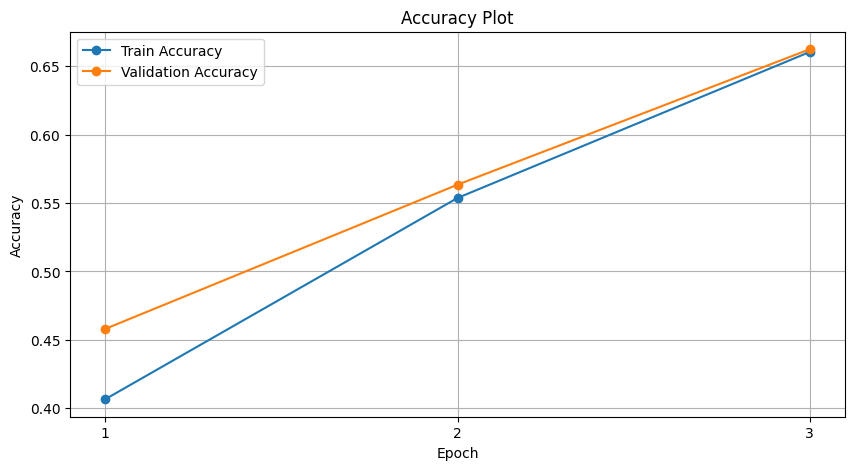

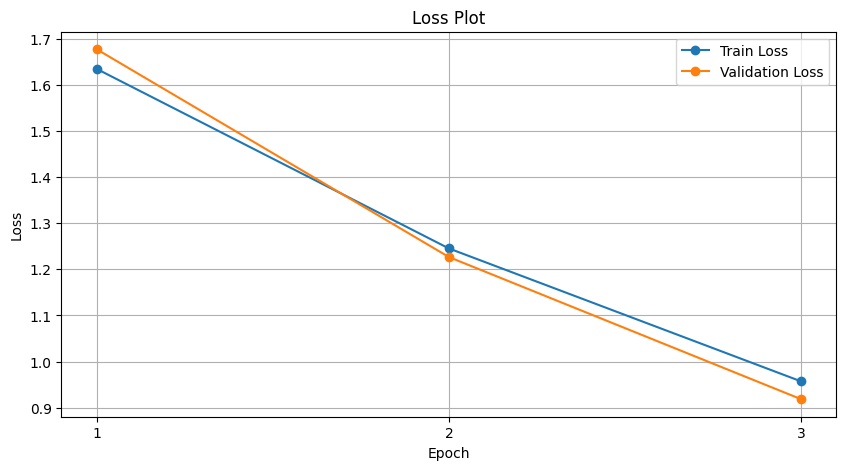

In [70]:
# Plot accuracy
plt.figure(figsize=(10, 5))
plt.plot(
    range(1, num_epochs + 1), results["train acc"], label="Train Accuracy", marker="o"
)
plt.plot(
    range(1, num_epochs + 1), results["val acc"], label="Validation Accuracy", marker="o"
)
plt.title("Accuracy Plot")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.xticks(range(1, num_epochs + 1))
plt.legend()
plt.grid(True)
plt.show()

# Plot loss
plt.figure(figsize=(10, 5))
plt.plot(
    range(1, num_epochs + 1), results["train loss"], label="Train Loss", marker="o"
)
plt.plot(
    range(1, num_epochs + 1), results["val loss"], label="Validation Loss", marker="o",
)
plt.title("Loss Plot")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.xticks(range(1, num_epochs + 1))
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# TODO

## Evaluation

Test your trained model (using the Test Dataloader that you have). Our goal is to reach an accuracy above `80%`

In [71]:
def test_network(
    model,
    criterion,
    test_loader,
    score_funcs=None,
    device="cpu",
):
    to_track = ["total time", "test loss"]
    for eval_score in score_funcs:
        to_track.append("test " + eval_score)

    # Initialization
    total_test_time = 0
    results = {}
    for item in to_track:
        results[item] = []

    model.to(device)
    model = model.eval()
    with torch.no_grad():
        total_test_time += run_epoch(
            model,
            None,
            test_loader,
            criterion,
            None,
            device,
            results,
            score_funcs,
            prefix="test",
            desc="Testing",
        )

        results["total time"].append(total_test_time)
    return results

In [73]:
test_results = test_network(
    net,
    criterion,
    testloader,
    score_funcs=score_funcs,
    device=device,
)
print(
    f"test accuracy: {test_results['test acc'][0]}\ntest loss: {test_results['test loss'][0]}"
)

Testing:   0%|          | 0/25 [00:00<?, ?it/s]

test accuracy: 0.707
test loss: 0.822627592086792


In [ ]:
# TODO

## Visualize incorrectly predicted samples from testset

Visualize *24* c images from testset that are incorrectly predicted by the model

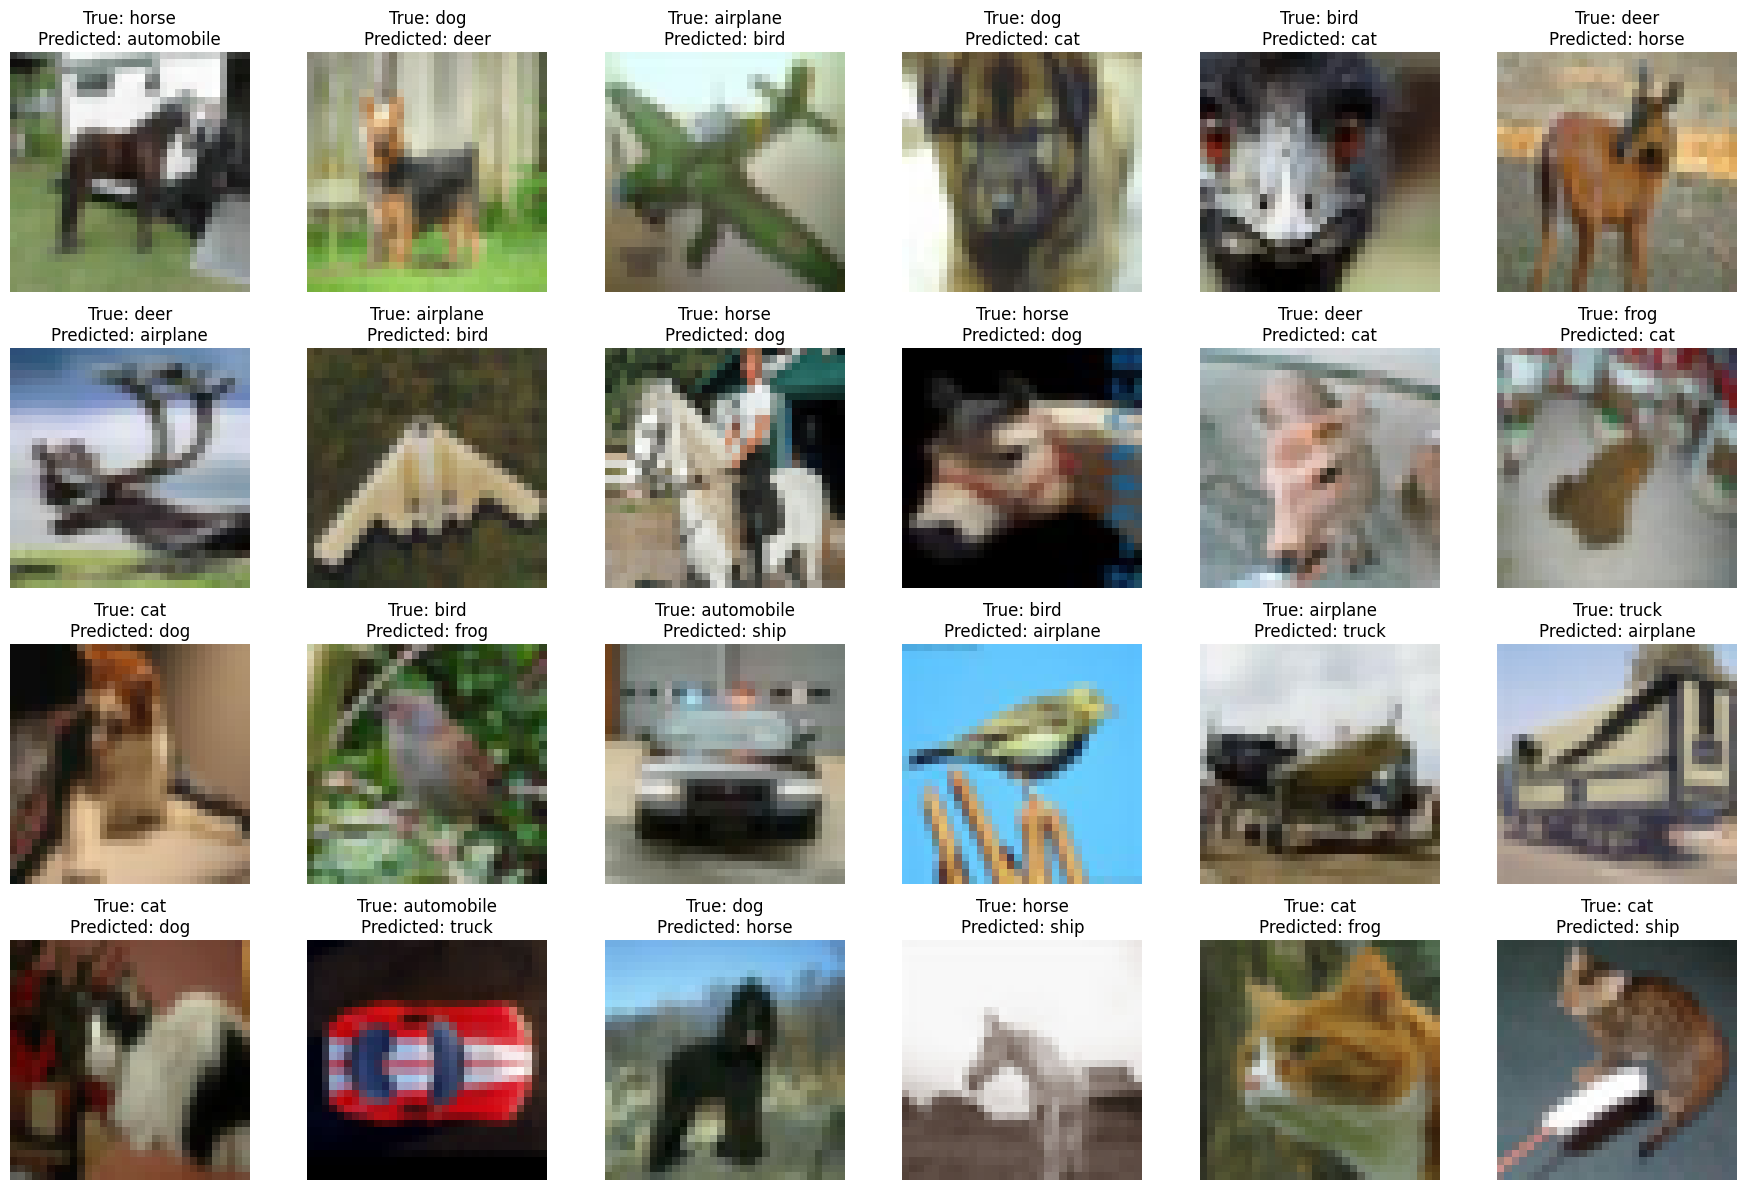

In [74]:
def visualize_images(images, labels, preds, classes_list):
    _, axes = plt.subplots(nrows=4, ncols=6, figsize=(18, 12))
    for i, ax in enumerate(axes.flat):
        ax.imshow(norminv(images[i]).permute(1, 2, 0).detach().cpu().numpy())
        ax.axis("off")
        ax.set_title(
            f"True: {classes_list[labels[i]]}\nPredicted: {classes_list[preds[i]]}"
        )
    plt.tight_layout()
    plt.show()


def get_misclassified_images(model, data_loader, device, num_images=24):
    misclassified_images = []
    true_labels = []
    predicted_labels = []

    model.eval()
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            misclassified_mask = predicted != labels
            misclassified_images.extend(images[misclassified_mask])
            true_labels.extend(labels[misclassified_mask].tolist())
            predicted_labels.extend(predicted[misclassified_mask].tolist())
            if len(misclassified_images) >= num_images:
                break

    return (
        misclassified_images[:num_images],
        true_labels[:num_images],
        predicted_labels[:num_images],
    )


misclassified_images, true_labels, predicted_labels = get_misclassified_images(
    net, testloader, device
)
visualize_images(
    misclassified_images, true_labels, predicted_labels, initial_trainset.classes
)

In [ ]:
# TODO

## Exploring the feature space

### Calculate the feature space for all training samples

You have trained and evaluated your model. Now, for each sample in the trainset, calculate it's "feature space" discussed in the model section. The result of this section should be a tensor of size `(50000, N)` saved in a variable (for later usage)

- **Hint 1:** define a tensor with dimension `(50000, N)` where *50000* is the size of the trainset and *N* is the dimension of the feature space

- **Hint 2:** Pay attension to the `shuffle` attribute of your train dataloader (If needed)

In [75]:
initial_trainloader = torch.utils.data.DataLoader(initial_trainset, batch_size=batch_size, num_workers=2)

N = 10
trainset_feature_space = torch.empty(0, N).to(device)
net.to(device)
net = net.eval()
with torch.no_grad():
    for inputs, _ in tqdm(initial_trainloader, desc="Prediction"):
        inputs = inputs.to(device)

        y_hat = net(inputs)
        trainset_feature_space = torch.cat((trainset_feature_space, y_hat), dim=0)

print(trainset_feature_space.shape)

Prediction:   0%|          | 0/125 [00:00<?, ?it/s]

torch.Size([50000, 10])


In [ ]:
# TODO

### K Nearest Neighbor in feature space

You already have calculated the feature spaces for trainset ($S$) in the previous section

1. Get 5 random samples from testset which are correctly predicted by the model.
2. for each sample, calculate it's "feature space" ($X$)
3. for each sample, calculate it's *5* nearest neighbors in "feature space" in the trainset (by comparing $X$ to each row in $S$) and visualize them


**Hint:** For finding the nearest neighbors in the feature space you can use `torch.linalg.norm` and `torch.topk`

In [76]:
def visualize_knn(img, neighbor_imgs):
    _, axes = plt.subplots(nrows=1, ncols=6, figsize=(18, 12))
    for i, ax in enumerate(axes.flat):
        if i==0:
            ax.imshow(norminv(img).permute(1, 2, 0).detach().cpu().numpy())
            ax.axis("off")
            ax.set_title(f"correctly classified image")
        else:
            ax.imshow(norminv(neighbor_imgs[i - 1]).permute(1, 2, 0).detach().cpu().numpy())
            ax.axis("off")
    plt.tight_layout()
    plt.show()

def get_correctly_classified_images(model, data_loader, device, num_images=5):
    correctly_classified_images = []
    true_labels = []

    model.eval()
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correctly_classified_mask = predicted == labels
            correctly_classified_images.extend(images[correctly_classified_mask])
            true_labels.extend(labels[correctly_classified_mask].tolist())
            if len(correctly_classified_images) >= num_images:
                break

    return (
        correctly_classified_images[:num_images],
        true_labels[:num_images],
    )


correctly_classified_images, true_labels = get_correctly_classified_images(
    net, testloader, device
)

correctly_classified_inputs = torch.stack(correctly_classified_images).to(device)

net.to(device)
net = net.eval()
with torch.no_grad():
    correctly_classified_embeddings = net(correctly_classified_inputs)

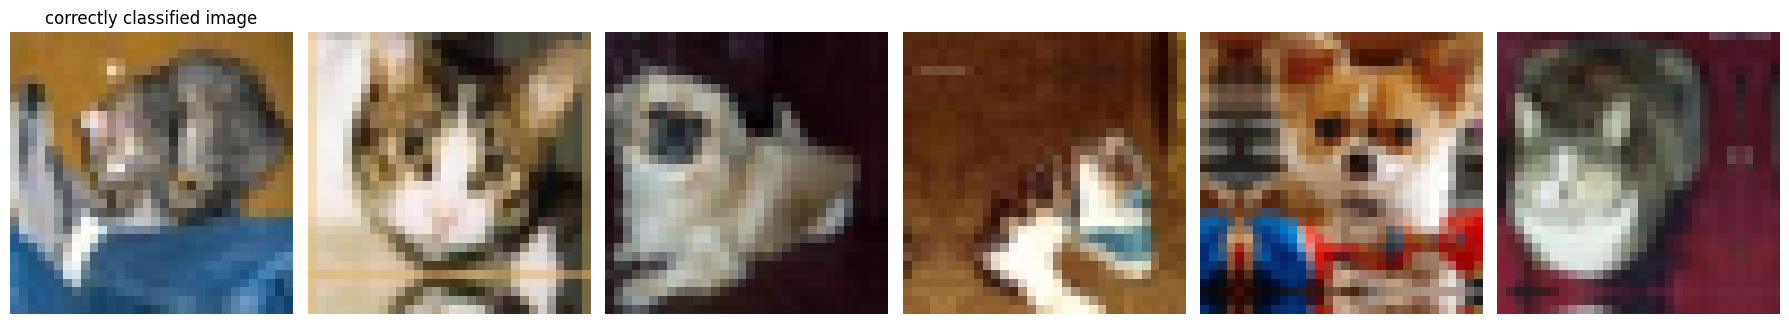

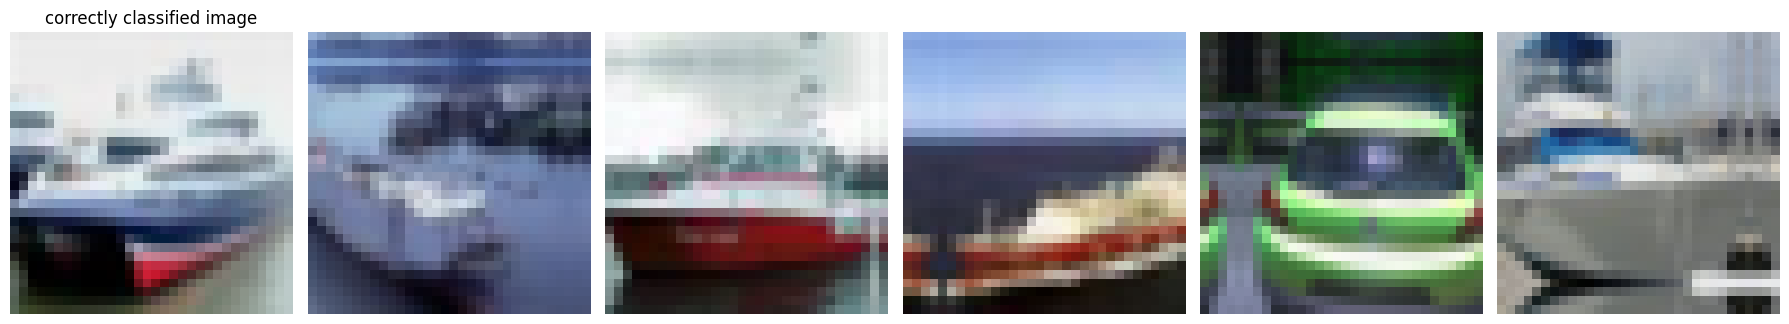

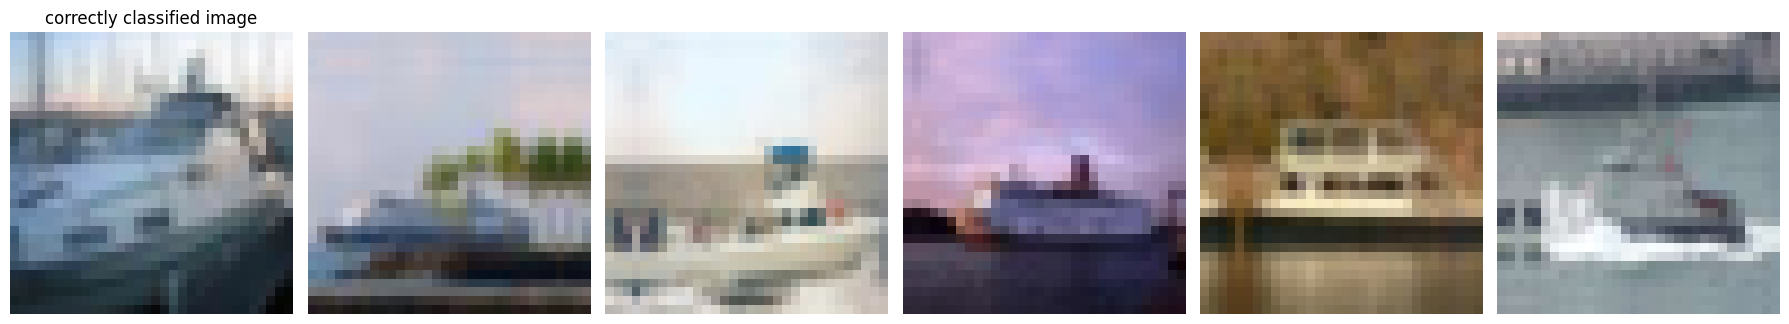

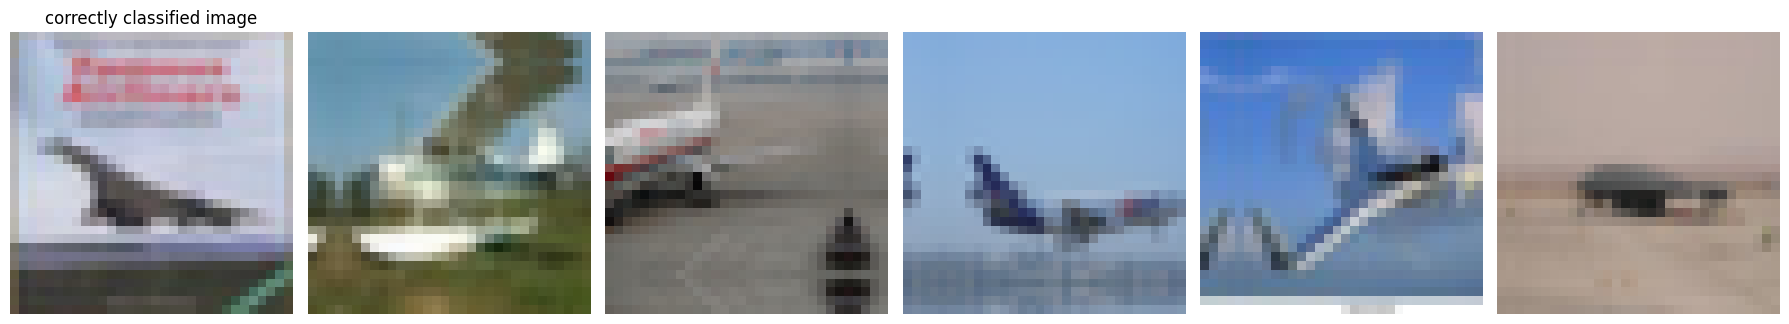

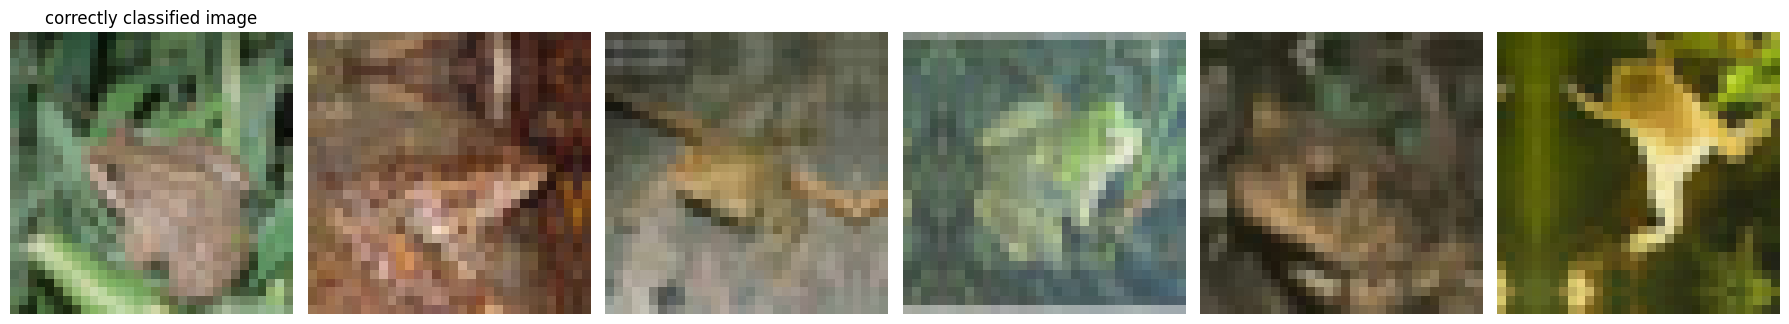

In [77]:
k_neighbors = 5
for i, emb in enumerate(correctly_classified_embeddings):
    distances = torch.linalg.norm(trainset_feature_space - emb, dim=1)
    _, neighbor_indices = torch.topk(-distances, k=k_neighbors)
    neighbor_imgs = [initial_trainset[idx][0] for idx in neighbor_indices]
    visualize_knn(correctly_classified_inputs[i], neighbor_imgs)

### TSNE

1. Sample $M$ ($2000$ would be enought) random samples from the trainset feature space (calculated in the above sections)
2. Now you have a vector of size `(M, N)` where $N$ is the dimension of the feature space
3. Using TSNE reduce $N$ to $2$ (Now you have a vector of size `(M, 2)`)
4. Visualize the points in a 2D plane (Set color of each point based on it's class)

**Hint:** You can use `sklearn.manifold.TSNE`

**Hint:** Use `plt.scatter(x, y, c=labels)`


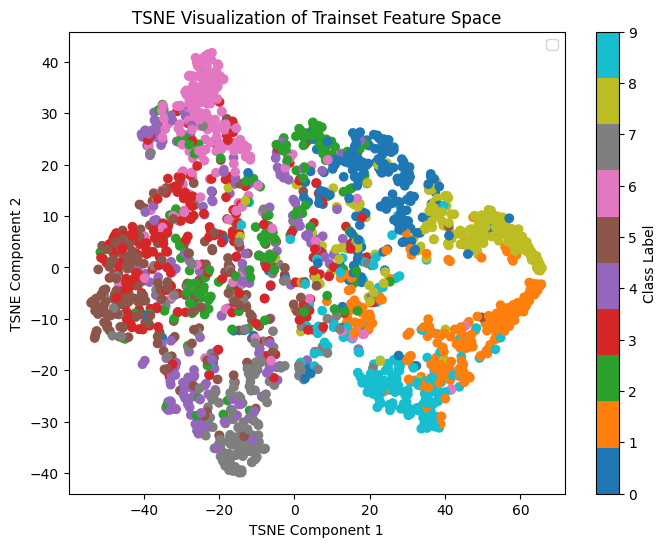

In [78]:
from sklearn.manifold import TSNE

M = 2000
random_indices = torch.randperm(len(trainset_feature_space))[:M]
random_samples = trainset_feature_space[random_indices]

tsne = TSNE(n_components=2, random_state=42)
tsne_features = tsne.fit_transform(random_samples.detach().cpu().numpy())
labels = [initial_trainset[idx][1] for idx in random_indices]

plt.figure(figsize=(8, 6))
plt.scatter(tsne_features[:, 0], tsne_features[:, 1], c=labels, cmap='tab10')
plt.title('TSNE Visualization of Trainset Feature Space')
plt.xlabel('TSNE Component 1')
plt.ylabel('TSNE Component 2')
plt.colorbar(label='Class Label')
plt.legend()
plt.show()

# CIFAR10 Colorization

In this part of the assignment, we want to do an image colorization task using PyTorch on CIFAR10 dataset. We want to train a model that colors  a black-and-white image.

## Import Libraries

Import needed libraries

In [79]:
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

In [80]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [81]:
num_epochs = 15
batch_size = 128
lr = 1e-3

## Custom Dataset

Define a custom dataset class by extensing `torch.utils.data.Dataset`

**Notice:** your dataset should output two things: black-and-white image and the RGB image

**Hint:** You don't have to reinvent the wheel. Your class should just be a wrapper for CIFAR10 dataset

In [82]:
class BlackAndWhiteCIFAR10(Dataset):
    """
    Define a custom dataset class by extending `torch.utils.data.Dataset`
    this class is a dataset for the CIFAR10 data in pytorch and it has the black and white image of the original CIFAR10 image as the data
    and the original RGB image as the target
    this class is just a wrapper for the torchvision.datasets.CIFAR10 class
    """

    def __init__(self, train=True, root="./data", download=True, transform=None):
        self.cifar10_dataset = torchvision.datasets.CIFAR10(
            root=root, train=train, download=download, transform=transform
        )

    def __len__(self):
        return len(self.cifar10_dataset)

    def __getitem__(self, index):
        rgb_img, _ = self.cifar10_dataset[index]
        black_white_img = transforms.Grayscale()(rgb_img)

        return black_white_img, rgb_img

## Transforms & Dataset & Dataloader

**Notice:** Use your defined custom dataset class for defining the datasets

In [83]:
classes = [
    "plane",
    "car",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
]

In [84]:
transform_train = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(
            mean=(0.5, 0.5, 0.5), std=(0.20, 0.20, 0.20), inplace=True
        ),
    ]
)

transform_test = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.20, 0.20, 0.20)),
    ]
)

In [85]:
initial_trainset = BlackAndWhiteCIFAR10(
    root="./data", train=True, download=True, transform=transform_train
)

Files already downloaded and verified


In [86]:
val_size = int(0.1 * len(initial_trainset))
trainset, valset = torch.utils.data.random_split(
    initial_trainset, (len(initial_trainset) - val_size, val_size)
)

In [87]:
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size, shuffle=True, num_workers=2
)
valloader = torch.utils.data.DataLoader(
    valset, batch_size=batch_size, shuffle=False, num_workers=2
)

## Dataset Visualization

Visualize your dataset (black-and-white image along with the RGB image) by sampling from your trainset

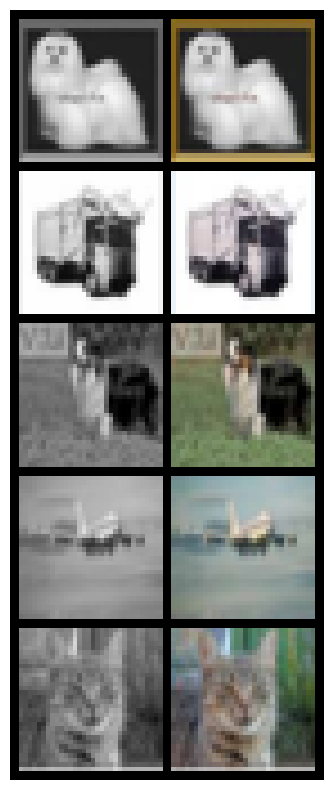

In [88]:
num_samples = 5
random_indices = torch.randperm(len(trainset))[:num_samples]

# Create a grid to display images
grid_images = []
for idx in random_indices:
    black_white_img, rgb_img = initial_trainset[idx]
    rgb_img = norminv(rgb_img)
    black_white_img = norminv(black_white_img)
    black_white_img = black_white_img.expand(3, -1, -1)
    grid_images.extend([black_white_img, rgb_img])

grid = torchvision.utils.make_grid(grid_images, nrow=2)

plt.figure(figsize=(10, 10))
plt.imshow(grid.permute(1, 2, 0))
plt.axis("off")
plt.show()

In [ ]:
# TODO

## Model

Define your model here (Input: black-and-white image, Output: RGB image)

**Hint:** You can implement an autoencoder that does the colorization task for you. UNet could be a viable option

In [89]:
import torch.nn as nn
from torch.nn.functional import relu


class ConvBlock(nn.Module):
    def __init__(
        self,
        in_channels,
        out_channels,        
    ):
        super(ConvBlock, self).__init__()
        self.e1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1) 
        self.e2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1) 
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2) 

    def forward(self, x):
        xe1 = relu(self.e1(x))
        xe2 = relu(self.e2(xe1))
        xp = self.pool(xe2)
        
        return xe2, xp


class TransConvBlock(nn.Module):
    def __init__(
        self,
        in_channels,
    ):
        super(TransConvBlock, self).__init__()
        self.upconv = nn.ConvTranspose2d(in_channels, in_channels//2, kernel_size=2, stride=2)
        self.d1 = nn.Conv2d(in_channels, in_channels//2, kernel_size=3, padding=1)
        self.d2 = nn.Conv2d(in_channels//2, in_channels//2, kernel_size=3, padding=1)

    def forward(self, x, skip_input):
        xu1 = self.upconv(x)
        xu11 = torch.cat([skip_input, xu1], dim=1)
        xd11 = relu(self.d1(xu11))
        xd12 = relu(self.d2(xd11))
        
        return xd12


class colorizationNet(nn.Module):
    def __init__(self):
        super(colorizationNet, self).__init__()

        self.conv_block1 = ConvBlock(1, 32)
        self.conv_block2 = ConvBlock(32, 64)
        self.conv_block3 = ConvBlock(64, 128)
        self.conv_block4 = ConvBlock(128, 256)

        self.e51 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.e52 = nn.Conv2d(512, 512, kernel_size=3, padding=1)

        self.trans_conv_block1 = TransConvBlock(512)
        self.trans_conv_block2 = TransConvBlock(256)
        self.trans_conv_block3 = TransConvBlock(128)
        self.trans_conv_block4 = TransConvBlock(64)
        
        self.outconv = nn.Conv2d(32, 3, kernel_size=1)

    def forward(self, x):
        xe12, xp1 = self.conv_block1(x)
        xe22, xp2 = self.conv_block2(xp1)
        xe32, xp3 = self.conv_block3(xp2)
        xe42, xp4 = self.conv_block4(xp3)        

        xe51 = relu(self.e51(xp4))
        xe52 = relu(self.e52(xe51))
        
        xd12 = self.trans_conv_block1(xe52, xe42)
        xd22 = self.trans_conv_block2(xd12, xe32)
        xd32 = self.trans_conv_block3(xd22, xe22)
        xd42 = self.trans_conv_block4(xd32, xe12)

        out = self.outconv(xd42)

        return out

## Train

Train your model

Tasks:
- [ ] Things that are needed to be printed in each epoch:
  - Number of epoch
  - Train loss
  - Validation loss
- [ ] save train/validation loss (of each epoch) in an array for later usage

In [90]:
net = colorizationNet()

In [91]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(params=net.parameters(), lr=lr)

In [ ]:
# import tqdm
# from time import time

In [ ]:
# def train_epoch(
#     net: torch.nn.Module,
#     criterion: torch.nn.Module,
#     optimizer: torch.optim.Optimizer,
#     dataloader: torch.utils.data.DataLoader,
# ):
#     pass


# def eval_epoch(
#     net: torch.nn.Module,
#     criterion: torch.nn.Module,
#     dataloader: torch.utils.data.DataLoader,
#     test_mode: bool = False,
# ):
#     pass

In [ ]:
# epochs = 

# for e in range(epochs):
#     pass

In [92]:
score_funcs = {}

results = train_network(
    net,
    optimizer,
    criterion,
    None,
    trainloader,
    val_loader=valloader,
    score_funcs=score_funcs,
    epochs=num_epochs,
    device=device,
    log_items=("train loss", "val loss"),
)

Epoch:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1]: train loss: 0.2111, val loss: 0.1443, 


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [2]: train loss: 0.1397, val loss: 0.1396, 


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [3]: train loss: 0.1345, val loss: 0.1391, 


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [4]: train loss: 0.1317, val loss: 0.1327, 


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [5]: train loss: 0.1291, val loss: 0.1315, 


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [6]: train loss: 0.1280, val loss: 0.1355, 


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [7]: train loss: 0.1258, val loss: 0.1290, 


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [8]: train loss: 0.1248, val loss: 0.1355, 


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [9]: train loss: 0.1241, val loss: 0.1297, 


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [10]: train loss: 0.1220, val loss: 0.1306, 


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [11]: train loss: 0.1213, val loss: 0.1301, 


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [12]: train loss: 0.1198, val loss: 0.1289, 


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [13]: train loss: 0.1180, val loss: 0.1287, 


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [14]: train loss: 0.1169, val loss: 0.1286, 


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [15]: train loss: 0.1155, val loss: 0.1283, 


### Visualize Loss plot

Using the arrays that you have (from task 2 in the above section), visualize the loss plot (train and validation together)

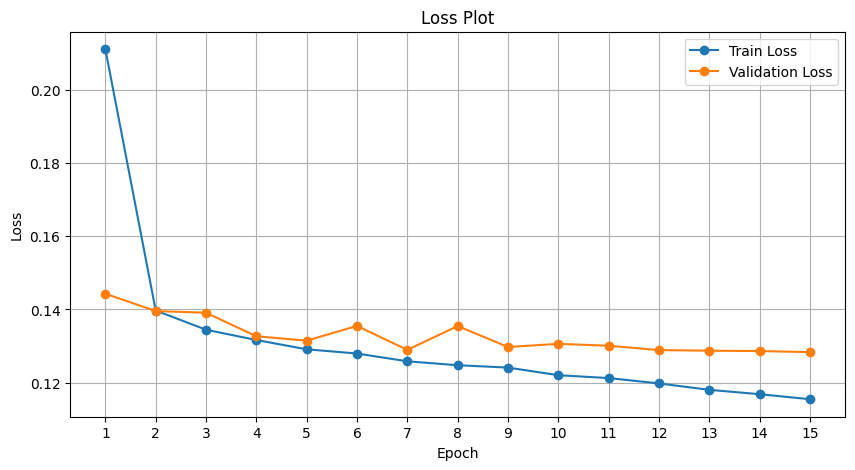

In [93]:
# Plot loss
plt.figure(figsize=(10, 5))
plt.plot(
    range(1, num_epochs + 1), results["train loss"], label="Train Loss", marker="o"
)
plt.plot(
    range(1, num_epochs + 1), results["val loss"], label="Validation Loss", marker="o",
)
plt.title("Loss Plot")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.xticks(range(1, num_epochs + 1))
plt.legend()
plt.grid(True)
plt.show()

## Evaluation

1. Sample 36 random samples from testset (your own dataset class)
2. Give each of the 36 samples to your trained model and get the outputs
3. Visualize `input` (black-and-white image), `output` (output of the model with the given black-and-white input image) and `ground truth` (the actual RGB image)



In [94]:
testset = BlackAndWhiteCIFAR10(
    root="./data", train=False, download=True, transform=transform_test
)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=batch_size, shuffle=False, num_workers=2
)

Files already downloaded and verified


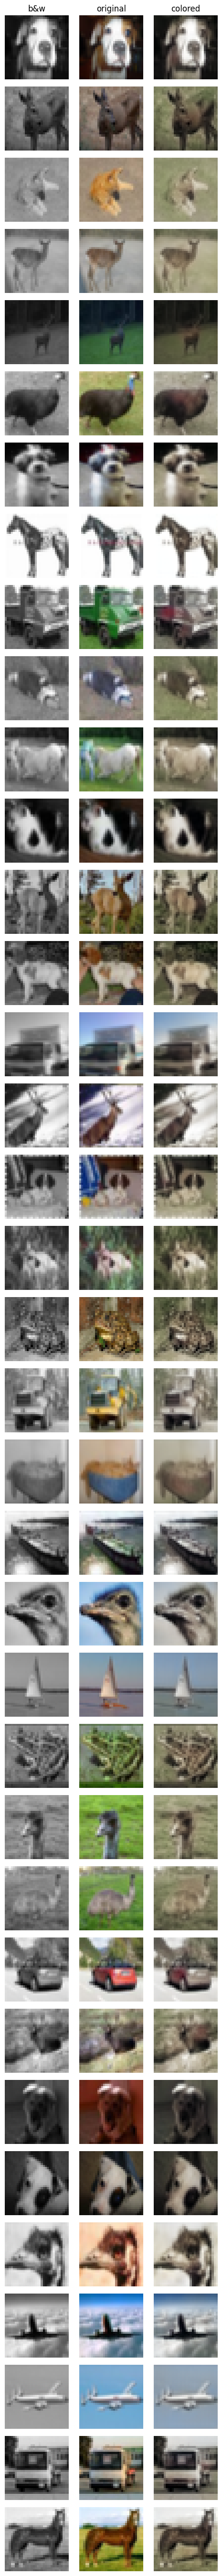

In [122]:
def visualize_images(images, titles=None):
    num_images = len(images)
    num_cols = 3
    num_rows = num_images // num_cols + (1 if num_images % num_cols != 0 else 0)

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(5, 1.5*num_rows))

    for i, ax in enumerate(axes.flat):
        if i < num_images:
            ax.imshow(images[i].permute(1, 2, 0))
            ax.axis('off')
    for j in range(num_cols):
        axes[0, j].set_title(titles[j])

    plt.tight_layout()
    plt.show()
    
N = 36
random_indices = torch.randperm(len(testset))[:N]
random_samples = [testset[idx] for idx in random_indices]
random_inputs = torch.stack([t[0] for t in random_samples]).to(device)
net.to(device)
net = net.eval()
with torch.no_grad():
    random_inputs.to(device)
    colored_imgs = net(random_inputs)
    colored_imgs = colored_imgs.detach().cpu()

images = []
for (bw_img, rgb_img), colored_img in zip(random_samples, colored_imgs):
    bw_img = norminv(bw_img)
    bw_img = bw_img.expand(3, -1, -1)
    rgb_img = norminv(rgb_img)
    colored_img = norminv(colored_img)
    images.extend([bw_img, rgb_img, colored_img])

titles = ["b&w", "original", "colored"]
visualize_images(images, titles)